## Heart sounds analysis and classification with Deep Learning

#### Background
If you press a smartphone microphone up to your heart or use a stethescope you can hear your heart beating, usually a bit faster than one beat per second. In healthy adults, there are two parts of each heartbeat cycle, often described as a "lub" sound and a "dub" (or "dup"). These occur close together in sequence withing each heartbeat and the pair repeats about once per second. These are also called the first and second heart sounds, sometimes labeled S1 and S2. These two sounds are produced by the closing of the atrioventricular valves (S1) and then semilunar valves (S2).

Doctors are trained and tested on their ability to detect abnormalities in these sounds that can indicate health problems. All doctors, not just internists are required to learn this skill in the US. But machines have proven to be more accurate at some diagnoses, especially when compared to experienced doctors who have not recently listed to training examples of normal and abnormal heartbeat sounds.

#### Problem 
An estimated 17.1 million people died from CVDs in 2004, representing 29% of all global deaths. Of these deaths, an estimated 7.2 million were due to coronary heart disease. Any method which can help to detect signs of heart disease c
 
The problem is of particular interest to machine learning researchers as it involves classification of audio sample data, where distinguishing between classes of interest is non-trivial. Data is gathered in real-world situations and frequently contains background noise of every conceivable type. The differences between heart sounds corresponding to different heart symptoms can also be extremely subtle and challenging to separate. Success in classifying this form of data requires extremely robust classifiers. Despite its medical significance, to date this is a relatively unexplored application for machine learning. Source: Classifying Heart Sounds Challenge [http://www.peterjbentley.com/heartchallenge/]

This is my first attempt to create a deep learning classification model based on RNN-LSTM as a primary choice. The goal of this notebook is optimized the model for better accuracy overtime. welcome any auggestion or question.

In [4]:
import sys
print('sys.executable: ', sys.executable)
import os
print('     os.getcwd: ', os.getcwd())
# import warnings
# warnings.filterwarnings("ignore")
import os
import pandas as pd
import librosa.display
import glob 
import matplotlib.pyplot as plt
import seaborn
import requests
seaborn.set_style()
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 20
from IPython.display import display

sys.executable:  /Users/hobs/opt/anaconda3/envs/dsdh/bin/python
     os.getcwd:  /Users/hobs/code/teaching/ucsd/dsdh/jupyter-notebooks/server


In [2]:
DATA_DIR = "heartbeat-sounds"
DATA_URL = "https://totalgood.org/midata/teaching/" + DATA_DIR
SAMPLE_RATE = 16000  # 16 kHz
MAX_SOUND_CLIP_DURATION = 12  # 12 s

In [3]:
print(os.path.abspath(os.path.expanduser(os.curdir)))
if not os.path.isdir(DATA_DIR):
    os.makedirs(DATA_DIR, exist_ok=True)
for p in os.listdir(DATA_DIR):
    print(p)

/Users/hobs/code/teaching/ucsd/dsdh/jupyter-notebooks/server
set_a_timing.csv
set_a.csv
set_b.csv


### EDA (Explorator Data Analysis)

The audio files are of varying lengths, between 1 second and 30 seconds (some have been clipped to reduce excessive noise and provide the salient fragment of the sound).

Most information in heart sounds is contained in the low frequency components, with noise in the higher frequencies. It is common to apply a low-pass filter at 195 Hz. Fast Fourier transforms are also likely to provide useful information about volume and frequency over time. More domain-specific knowledge about the difference between the categories of sounds is provided below.

let's check what is inside each directory and content and input data organization

#### Some utilities to download and load CSV and WAV files:

In [32]:
def download_url(url, filename=None):
    filename = os.path.split(url)[-1] if filename is None else filename
    filepath = os.path.join(DATA_DIR, filepath)
    print(f'Downloading: {urlpath}')
    print(f'         to: {filepath}')
    os.makedirs(os.path.dirname(filepath, exist_ok=True))
    with open(filepath, 'wb') as out_file:
        with contextlib.closing(urllib.request.urlopen(url)) as fp:
            block_size = 1024 * 8
            while True:
                block = fp.read(block_size)
                if not block:
                    break
                out_file.write(block)
    return filepath

def read_file(filepath):
    if filepath.lower().endswith('.wav'):
        with open(filepath, 'rb') as fin:
            return fin.read()
    return pd.read_csv(filepath)

def get_data(filename):
    filepath = os.path.join(DATA_DIR, filename)
    urlpath = os.path.join(DATA_URL, filename)
    
    try:
        data = read_file(filepath)
    except (OSError, FileNotFoundError) as e:
        filepath = download_url(urlpath)
        df = pd.read_csv(filepath)
    for c in df.columns:
        if str(c).startswith('Unnamed: '):
            del df[c]
    return df

In [33]:
set_a = get_data("set_a.csv")
display(set_a.describe(include='all'))

dataset                           fname     label  sublabel
count      176                             176       124       0.0
unique       1                             176         4       NaN
top          a  set_a/normal__201103101140.wav  artifact       NaN
freq       176                               1        40       NaN
mean       NaN                             NaN       NaN       NaN
std        NaN                             NaN       NaN       NaN
min        NaN                             NaN       NaN       NaN
25%        NaN                             NaN       NaN       NaN
50%        NaN                             NaN       NaN       NaN
75%        NaN                             NaN       NaN       NaN
max        NaN                             NaN       NaN       NaN

In [34]:
set_a_timing = get_data("set_a_timing.csv")
display(set_a_timing.head())
display(set_a_timing.describe(include='all'))

dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

dataset                           fname     label  sublabel
count      176                             176       124       0.0
unique       1                             176         4       NaN
top          a  set_a/normal__201103101140.wav  artifact       NaN
freq       176                               1        40       NaN
mean       NaN                             NaN       NaN       NaN
std        NaN                             NaN       NaN       NaN
min        NaN                             NaN       NaN       NaN
25%        NaN                             NaN       NaN       NaN
50%        NaN                             NaN       NaN       NaN
75%        NaN                             NaN       NaN       NaN
max        NaN                             NaN       NaN       NaN

In [35]:
set_b = get_data("set_b.csv")
set_b.head()

dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

In [38]:
# merge both set-a and set-b
frames = [set_a, set_b]
train_ab = pd.concat(frames)
train_ab.describe(include='all')

dataset                           fname     label  sublabel
count      352                             352       248       0.0
unique       1                             176         4       NaN
top          a  set_a/normal__201103101140.wav  artifact       NaN
freq       352                               2        80       NaN
mean       NaN                             NaN       NaN       NaN
std        NaN                             NaN       NaN       NaN
min        NaN                             NaN       NaN       NaN
25%        NaN                             NaN       NaN       NaN
50%        NaN                             NaN       NaN       NaN
75%        NaN                             NaN       NaN       NaN
max        NaN                             NaN       NaN       NaN

In [41]:
#get all unique labels
train_ab['label'] = train_ab['label'].fillna('other')
nb_classes = train_ab['label'].value_counts()

print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))
display(nb_classes)

Number of training examples= 352   Number of classes= 5


other       104
artifact     80
murmur       68
normal       62
extrahls     38
Name: label, dtype: int64

Note: nan label indicate unclassified and unlabel test files

Min samples per category =  38
Max samples per category =  104


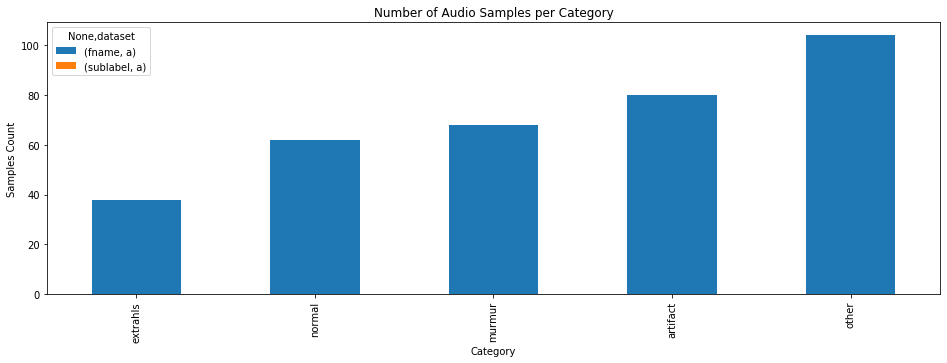

In [42]:
# visualize data distribution by category
category_group = train_ab.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))

In [26]:
print('Minimum samples per category = ', min(train_ab.label.value_counts()))
print('Maximum samples per category = ', max(train_ab.label.value_counts()))

Minimum samples per category =  38
Maximum samples per category =  80


### Explore an example sound file

#### 1. Normal case
In the Normal category there are normal, healthy heart sounds. These may contain noise in the final second of the recording as the device is removed from the body. They may contain a variety of background noises (from traffic to radios). They may also contain occasional random noise corresponding to breathing, or brushing the microphone against clothing or skin. A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub” (when the heart rate is less than 140 beats per minute)(source: Rita Getz)

In [27]:
normal_file = get_data("set_a/normal__201106111136.wav")

NameError: name 'INPUT_DIR' is not defined

In [13]:
# heart it
import IPython.display as ipd
ipd.Audio(normal_file) 

In [14]:
# Load use wave 
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [15]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


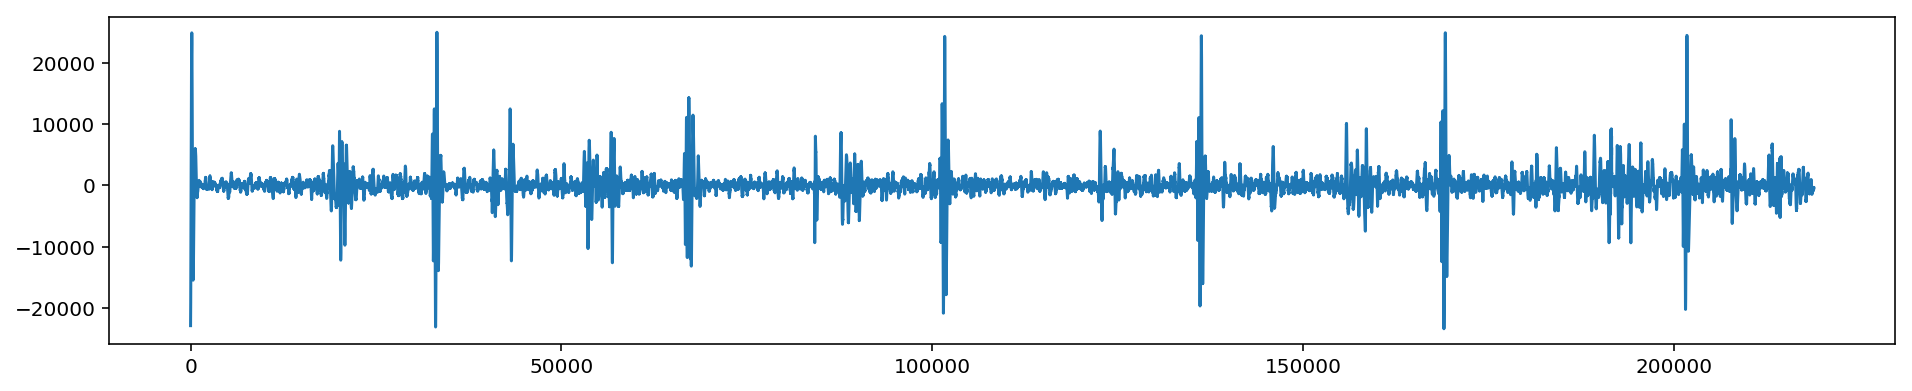

In [16]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.plot(data, '-', );

In [17]:
# Load using Librosa
y, sr = librosa.load(normal_file, duration=5)   #default sampling rate is 22 HZ
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)

duration: 4.963809523809524
(109452,) 22050


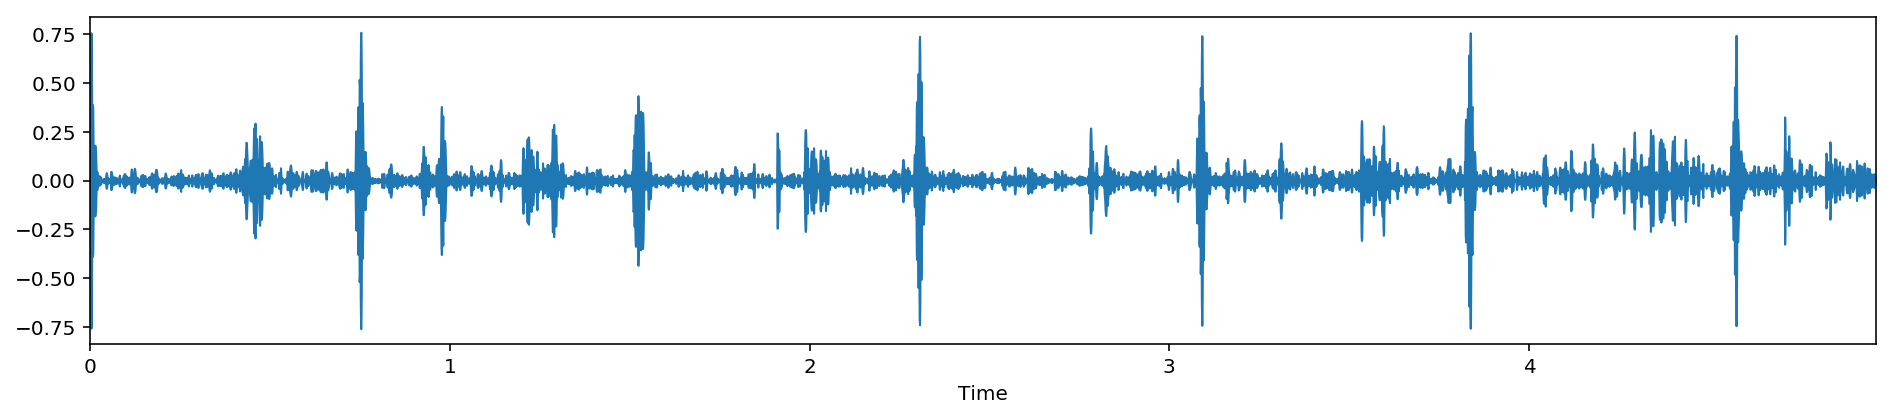

In [18]:
# librosa plot
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y, sr=sr)

#### 2. Murmur 
Heart murmurs sound as though there is a “whooshing, roaring, rumbling, or turbulent fluid” noise in one of two temporal locations: (1) between “lub” and “dub”, or (2) between “dub” and “lub”. They can be a symptom of many heart disorders, some serious. There will still be a “lub” and a “dub”. One of the things that confuses non-medically trained people is that murmurs happen between lub and dub or between dub and lub; not on lub and not on dub.(source: Rita Getz)

In [19]:
# murmur case
murmur_file=INPUT_DIR+"/set_a/murmur__201108222231.wav"
y2, sr2 = librosa.load(murmur_file,duration=5)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y2.shape,sr2)

duration: 4.963809523809524
(110250,) 22050


In [20]:
# heart it
import IPython.display as ipd
ipd.Audio(murmur_file) 

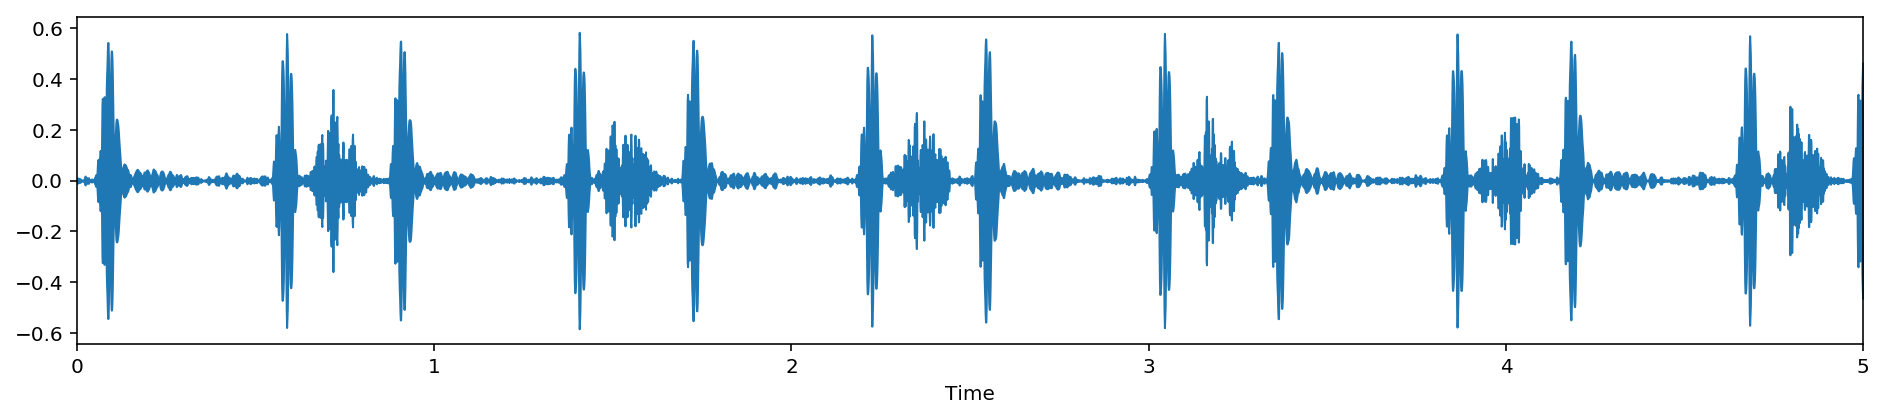

In [21]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y2, sr=sr2)

#### 3. Extrasystole 
Extrasystole sounds may appear occasionally and can be identified because there is a heart sound that is out of rhythm involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a “lub dub-dub”. (This is not the same as an extra heart sound as the event is not regularly occuring.) An extrasystole may not be a sign of disease. It can happen normally in an adult and can be very common in children. However, in some situations extrasystoles can be caused by heart diseases. If these diseases are detected earlier, then treatment is likely to be more effective. (source: Rita Getz)

In [22]:
# Extrasystole case
extrastole_file=INPUT_DIR+"/set_b/extrastole__127_1306764300147_C2.wav"
y3, sr3 = librosa.load(extrastole_file, duration=5)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y3.shape,sr3)

duration: 4.963809523809524
(103106,) 22050


In [23]:
# heart it
import IPython.display as ipd
ipd.Audio(extrastole_file) 

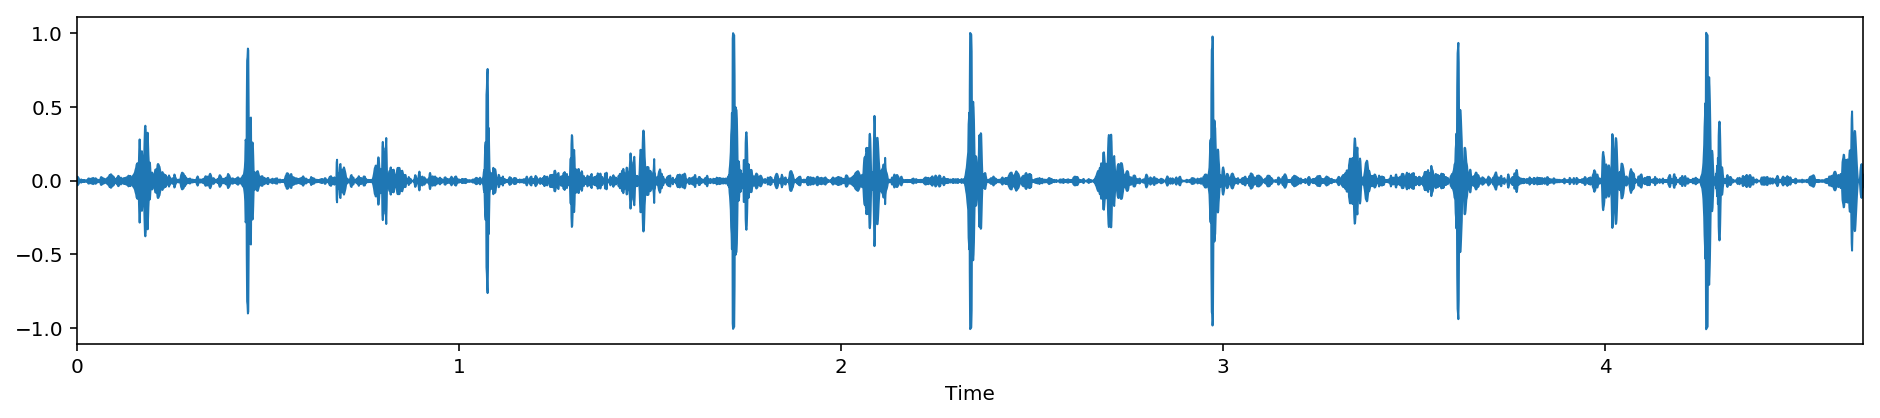

In [24]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y3, sr=sr3)

#### 4. Artifact 
In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.(source: Rita Getz)

In [25]:
# sample file
artifact_file=INPUT_DIR+"/set_a/artifact__201012172012.wav"
y4, sr4 = librosa.load(artifact_file, duration=5)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y4.shape,sr4)

duration: 4.963809523809524
(110250,) 22050


In [26]:
# heart it
import IPython.display as ipd
ipd.Audio(artifact_file) 

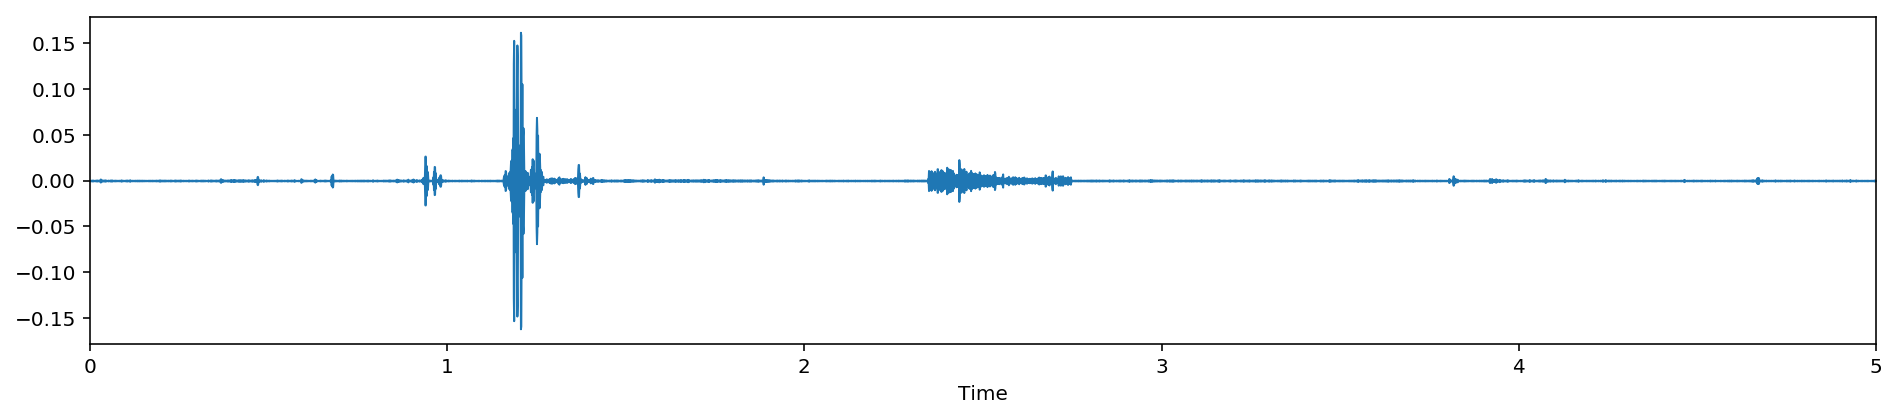

In [27]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y4, sr=sr4)

#### 5. Extra Heart Sound 
In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.(source: Rita Getz)

In [28]:
# sample file
extrahls_file=INPUT_DIR+"/set_a/extrahls__201101070953.wav"
y5, sr5 = librosa.load(extrahls_file, duration=5)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y5.shape,sr5)

duration: 4.963809523809524
(110250,) 22050


In [29]:
# heart it
import IPython.display as ipd
ipd.Audio(extrahls_file) 

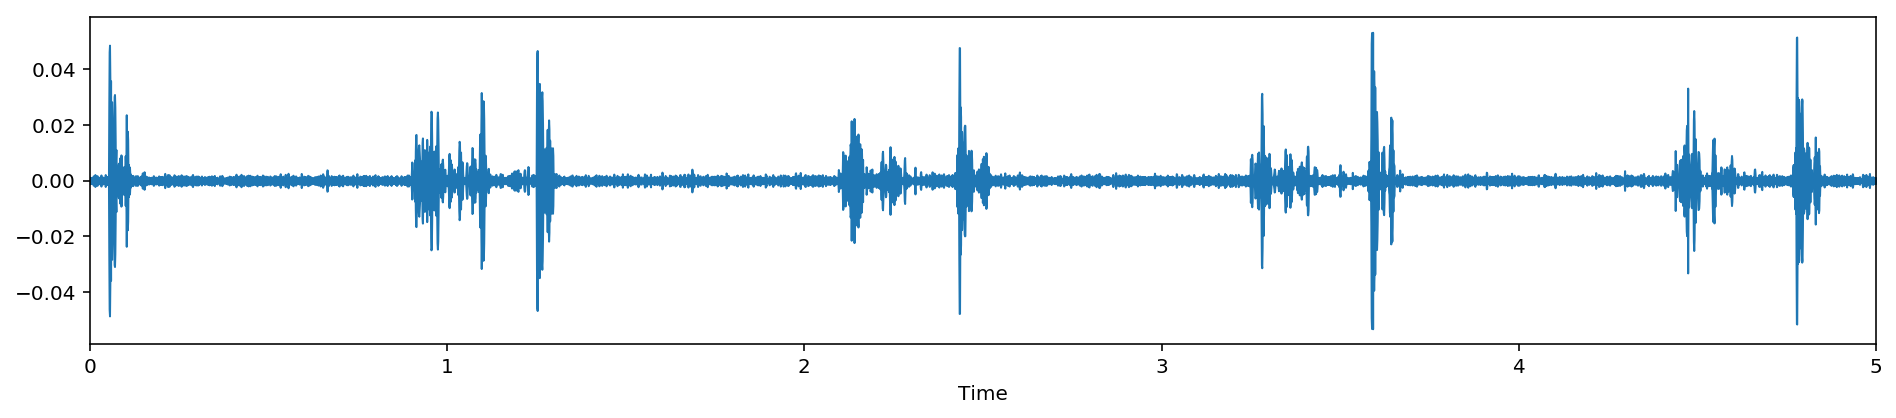

In [30]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y5, sr=sr5)

### Audio Length
the lengths of the audio files in the dataset varies from 1 to 30 seconds long. for training purpose we use first 5 seconds of the audio. padd missing lenght for file smaller than 5 seconds. 


### Data Handling in Audio domain
As with all unstructured data formats, audio data has a couple of preprocessing steps which have to be followed before it is presented for analysis. Another way of representing audio data is by converting it into a different domain of data representation, namely the frequency domain.

![frequency domain] https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/08/23212155/time_freq.png

There are a few more ways in which audio data can be represented. example. using MFCs (Mel-Frequency cepstrums)

General Audio Features
- Time Domain features (eg. RMSE of waveform)
- Frequency domain features (eg. Amplitude of individual freuencies)
- Perceptual features (eg. MFCC)
- Windowing features (eg. Hamming distances of windows)

After extracting these features, it is then sent to the machine learning model for further analysis.

### Sound Feature: MFCC 

Mel Frequency Cepstral Coefficient (MFCC) is by far the most successful feature used in the field of Speech Processing. Speech is a non-stationary signal. As such, normal signal processing techniques cannot be directly applied to it. 

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

MFCCs are commonly derived as follows:
-Take the Fourier transform of (a windowed excerpt of) a signal.
-Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
-Take the logs of the powers at each of the mel frequencies.
-Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
The MFCCs are the amplitudes of the resulting spectrum.

In general, a 39-dimensional feature vector is used which is composed of first 13 MFCCs and their corresponding 13 delta and 13 delta-delta.

In [31]:
# Here's a sample generate mfccs from a wave file
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"
#y, sr = librosa.load(sample_file, offset=7, duration=7)
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print (mfccs)

[[-2.45461310e+02 -2.91119158e+02 -4.02448048e+02 ... -3.67871637e+02
  -3.70708414e+02 -3.72469945e+02]
 [ 8.86406929e+01  9.88661324e+01  1.33256498e+02 ...  1.51281027e+02
   1.57261842e+02  1.52452273e+02]
 [ 1.03978908e+02  8.56985019e+01  2.37443259e+01 ...  2.91626730e+01
   2.93766991e+01  3.74463005e+01]
 ...
 [-1.33243318e+01 -8.19430184e+00 -1.18989196e+00 ...  9.66035179e-02
   6.24897256e-01  1.19534810e+00]
 [ 3.16322374e-01 -4.99245923e-01 -1.58862224e-01 ...  2.22770953e+00
  -2.15090204e-01  4.84898894e+00]
 [ 3.34313266e+00 -9.89011623e-01 -2.77108967e+00 ...  2.65077442e+00
  -1.38751247e+00  1.85793453e+00]]


In [32]:
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

[[-2.46578451e+02 -2.89466533e+02 -3.86061424e+02 ... -3.50173598e+02
  -3.51358336e+02 -3.55300579e+02]
 [ 1.09104030e+02  1.16516227e+02  1.30325863e+02 ...  1.49302754e+02
   1.54021441e+02  1.51842599e+02]
 [ 9.83255629e+01  7.55811535e+01  1.59119043e+01 ...  2.06767459e+01
   2.19900360e+01  3.01192216e+01]
 ...
 [ 4.26571311e+00  2.46345083e-01 -2.07913916e+00 ...  2.77262558e+00
  -1.40852842e+00  3.58013971e+00]
 [ 3.38976142e-01 -9.63366773e-01 -3.46149708e+00 ...  1.52363932e+00
   1.05708759e-01 -2.32015820e+00]
 [-5.24993637e+00 -2.43681813e+00 -1.56827403e+00 ...  2.74896890e-01
   5.19361242e-01 -6.77453398e+00]]


In [33]:
# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#print (mfccs)

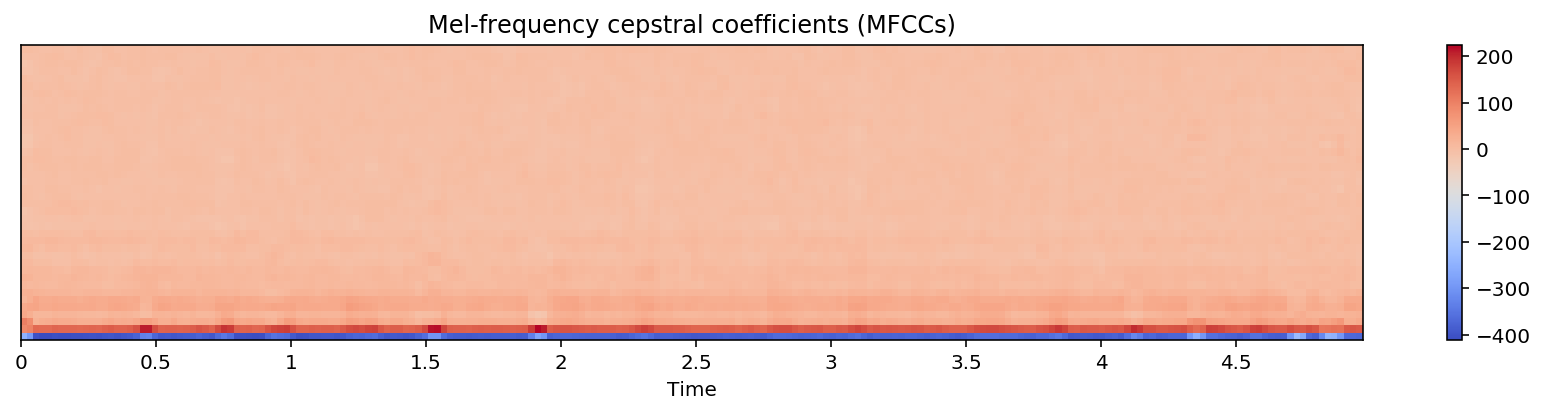

In [34]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

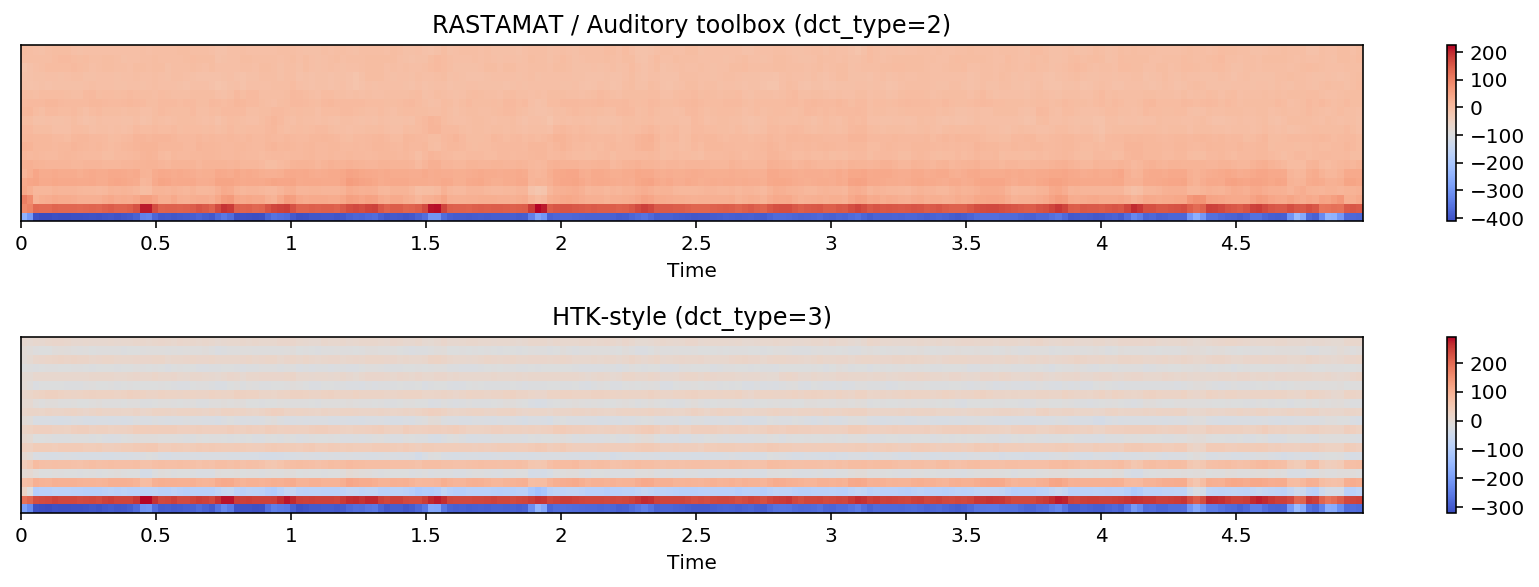

In [35]:
# Compare different DCT bases
m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=2)

#m_dct1 = librosa.feature.mfcc(y=y, sr=sr, dct_type=1)
plt.figure(figsize=(12, 6))
#plt.subplot(3, 1, 1)
#librosa.display.specshow(m_dct1, x_axis='time')
#plt.title('Discrete cosine transform (dct_type=1)')
#plt.colorbar()
m_htk = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
plt.subplot(3, 1, 2)
librosa.display.specshow(m_slaney, x_axis='time')
plt.title('RASTAMAT / Auditory toolbox (dct_type=2)')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(m_htk, x_axis='time')
plt.title('HTK-style (dct_type=3)')
plt.colorbar()
plt.tight_layout()

### Sound Feature: Onset 

#### onset detector

Basic onset detector. Locate note onset events by picking peaks in an onset strength envelope.
The peak_pick parameters were chosen by large-scale hyper-parameter optimization over the dataset provided 

In [36]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

array([0.48761905, 0.7662585 , 0.95201814, 1.25387755, 1.55573696,
       1.92725624, 2.32199546, 2.80961451, 3.11147392, 3.57587302,
       3.80807256, 3.85451247, 4.13315193, 4.36535147, 4.59755102,
       4.73687075, 4.85297052])

In [37]:
# use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y, sr=sr)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

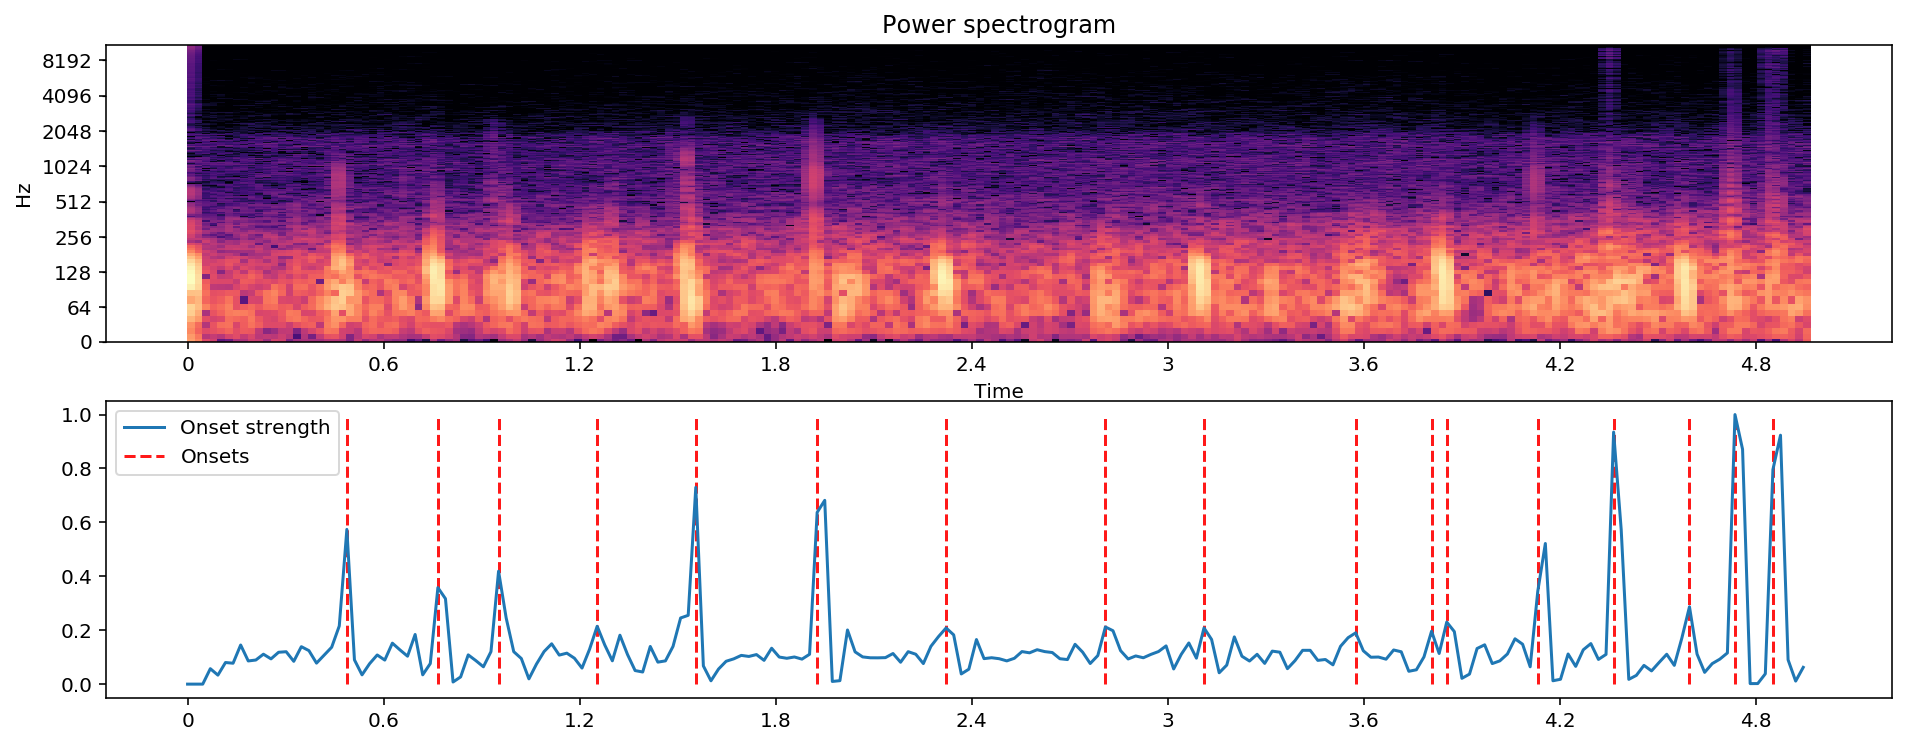

In [38]:
# visualize it
D = np.abs(librosa.stft(y))
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.axis('tight')
plt.legend(frameon=True, framealpha=0.75)


#### onset_backtrack
Backtrack detected onset events to the nearest preceding local minimum of an energy function.
This function can be used to roll back the timing of detected onsets from a detected peak amplitude to the preceding minimum. This is most useful when using onsets to determine slice points for segmentation

In [39]:
oenv = librosa.onset.onset_strength(y=y, sr=sr)
# Detect events without backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=oenv, backtrack=False)
# Backtrack the events using the onset envelope
onset_bt = librosa.onset.onset_backtrack(onset_raw, oenv)
# Backtrack the events using the RMS values
rms = librosa.feature.rms(S=np.abs(librosa.stft(y=y)))
onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])

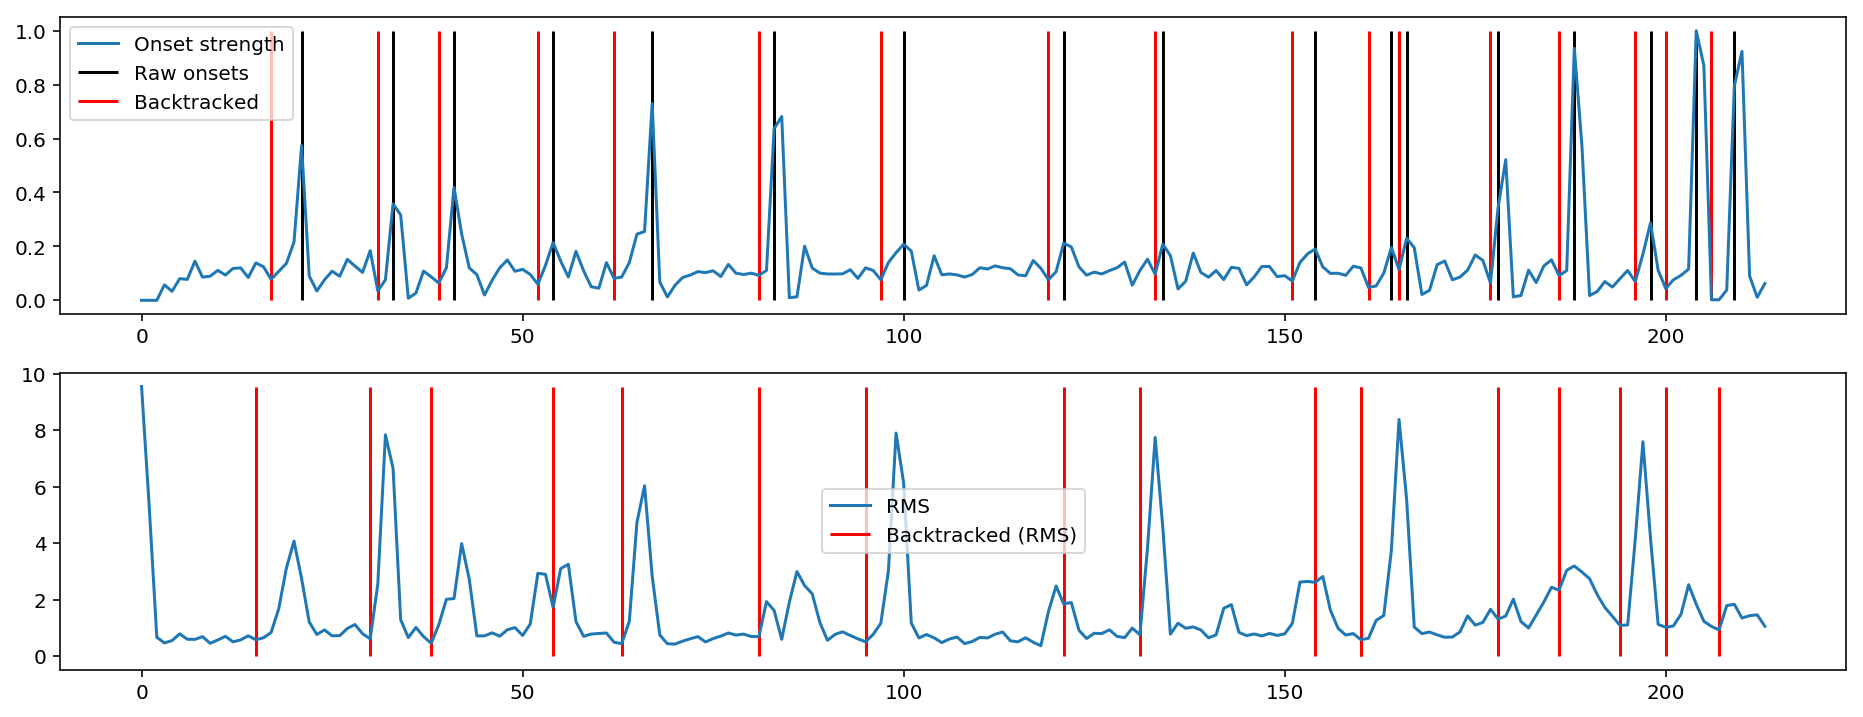

In [40]:
# Plot the results
plt.figure(figsize=(16, 6))
plt.subplot(2,1,1)
plt.plot(oenv, label='Onset strength')
plt.vlines(onset_raw, 0, oenv.max(), label='Raw onsets')
plt.vlines(onset_bt, 0, oenv.max(), label='Backtracked', color='r')
plt.legend(frameon=True, framealpha=0.75)
plt.subplot(2,1,2)
plt.plot(rms[0], label='RMS')
plt.vlines(onset_bt_rms, 0, rms.max(), label='Backtracked (RMS)', color='r')
plt.legend(frameon=True, framealpha=0.75)


#### onset strength
Compute a spectral flux onset strength envelope.
Onset strength at time t is determined by:
mean_f max(0, S[f, t] - ref_S[f, t - lag])
where ref_S is S after local max filtering along the frequency axis [1].
By default, if a time series y is provided, S will be the log-power Mel spectrogram.

Text(0.5,1,'Sub-band onset strength')

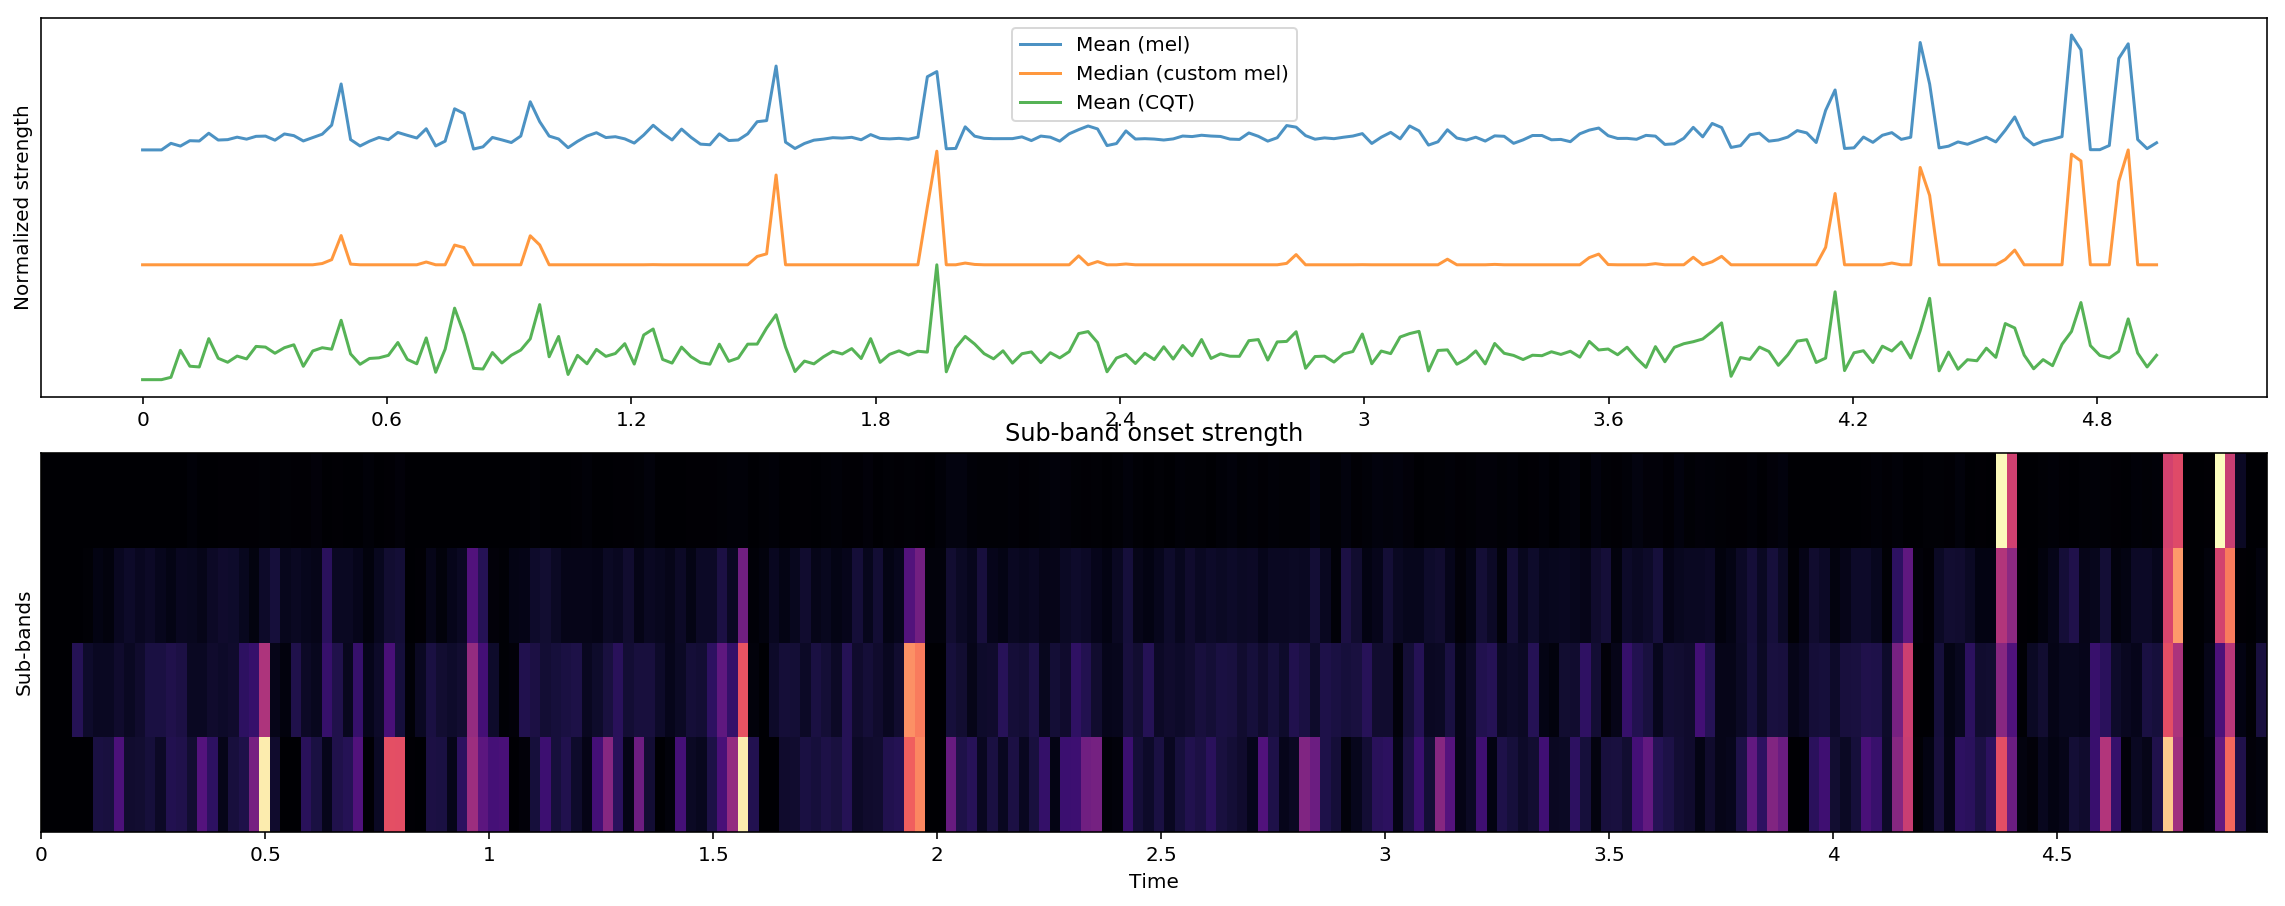

In [41]:
D = np.abs(librosa.stft(y))
times = librosa.frames_to_time(np.arange(D.shape[1]))

plt.figure(figsize=(16, 6))
#ax1 = plt.subplot(2, 1, 1)
#librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),y_axis='log', x_axis='time')
#plt.title('Power spectrogram')

# Construct a standard onset function
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
plt.subplot(2, 1, 1, sharex=ax1)
plt.plot(times, 2 + onset_env / onset_env.max(), alpha=0.8,label='Mean (mel)')

# median
onset_env = librosa.onset.onset_strength(y=y, sr=sr,aggregate=np.median,fmax=8000, n_mels=256)
plt.plot(times, 1+ (onset_env/onset_env.max()), alpha=0.8,label='Median (custom mel)')

# Constant-Q spectrogram instead of Mel
onset_env = librosa.onset.onset_strength(y=y, sr=sr,feature=librosa.cqt)
plt.plot(times, onset_env / onset_env.max(), alpha=0.8,label='Mean (CQT)')
plt.legend(frameon=True, framealpha=0.75)
plt.ylabel('Normalized strength')
plt.yticks([])
plt.axis('tight')
plt.tight_layout()

onset_subbands = librosa.onset.onset_strength_multi(y=y, sr=sr, channels=[0, 32, 64, 96, 128])
#plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 2)
librosa.display.specshow(onset_subbands, x_axis='time')
plt.ylabel('Sub-bands')
plt.title('Sub-band onset strength')

### Loading Data

In [42]:
print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))

Number of training examples= 832   Number of classes= 6


Loading od the audio data file will be based on content from directory since each filename is associate with the category type. hence, we can use csv file for cross reference check.  Based on directory content approach will be more flexible.

In [43]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5

# get audio data without padding highest qualify audio
def load_file_data_without_change(folder,file_names, duration=3, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0) 
        except Exception as e:
            print("Error encountered while parsing file: ", file)
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data


# get audio data with a fix padding may also chop off some file
def load_file_data (folder,file_names, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    for file_name in file_names:
        try:
            sound_file=folder+file_name
            print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
            X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", file)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

In [44]:
# simple encoding of categories, limited to 3 types
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['artifact','murmur','normal']
# {'artifact': 0, 'murmur': 1, 'normal': 3}
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
# map integer to label text
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'artifact': 0, 'murmur': 1, 'normal': 2}
 
{0: 'artifact', 1: 'murmur', 2: 'normal'}


In [45]:
# load dataset-a, keep them separate for testing purpose
import os, fnmatch

A_folder=INPUT_DIR+'/set_a/'
# set-a
A_artifact_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'artifact*.wav')
A_artifact_sounds = load_file_data(folder=A_folder,file_names=A_artifact_files, duration=MAX_SOUND_CLIP_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'normal*.wav')
A_normal_sounds = load_file_data(folder=A_folder,file_names=A_normal_files, duration=MAX_SOUND_CLIP_DURATION)
A_normal_labels = [2 for items in A_normal_sounds]

A_extrahls_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_file_data(folder=A_folder,file_names=A_extrahls_files, duration=MAX_SOUND_CLIP_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'murmur*.wav')
A_murmur_sounds = load_file_data(folder=A_folder,file_names=A_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
A_murmur_labels = [1 for items in A_murmur_files]

# test files
A_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_a'), 'Aunlabelledtest*.wav')
A_unlabelledtest_sounds = load_file_data(folder=A_folder,file_names=A_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
A_unlabelledtest_labels = [-1 for items in A_unlabelledtest_sounds]

print ("loaded dataset-a")

load file  ../input/set_a/artifact__201105060108.wav
fixing audio lenght : artifact__201105060108.wav
load file  ../input/set_a/artifact__201105040918.wav
fixing audio lenght : artifact__201105040918.wav
load file  ../input/set_a/artifact__201106161016.wav
fixing audio lenght : artifact__201106161016.wav
load file  ../input/set_a/artifact__201106040947.wav
fixing audio lenght : artifact__201106040947.wav
load file  ../input/set_a/artifact__201106040722.wav
fixing audio lenght : artifact__201106040722.wav
load file  ../input/set_a/artifact__201105280851.wav
fixing audio lenght : artifact__201105280851.wav
load file  ../input/set_a/artifact__201106010559.wav
fixing audio lenght : artifact__201106010559.wav
load file  ../input/set_a/artifact__201106141701.wav
fixing audio lenght : artifact__201106141701.wav
load file  ../input/set_a/artifact__201106041452.wav
fixing audio lenght : artifact__201106041452.wav
load file  ../input/set_a/artifact__201106221254.wav
fixing audio lenght : artifac

In [46]:
%%time
# load dataset-b, keep them separate for testing purpose 
B_folder=INPUT_DIR+'/set_b/'
# set-b
B_normal_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'normal*.wav')  # include noisy files
B_normal_sounds = load_file_data(folder=B_folder,file_names=B_normal_files, duration=MAX_SOUND_CLIP_DURATION)
B_normal_labels = [2 for items in B_normal_sounds]

B_murmur_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'murmur*.wav')  # include noisy files
B_murmur_sounds = load_file_data(folder=B_folder,file_names=B_murmur_files, duration=MAX_SOUND_CLIP_DURATION)
B_murmur_labels = [1 for items in B_murmur_files]

B_extrastole_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'extrastole*.wav')
B_extrastole_sounds = load_file_data(folder=B_folder,file_names=B_extrastole_files, duration=MAX_SOUND_CLIP_DURATION)
B_extrastole_labels = [1 for items in B_extrastole_files]

#test files
B_unlabelledtest_files = fnmatch.filter(os.listdir(INPUT_DIR+'/set_b'), 'Bunlabelledtest*.wav')
B_unlabelledtest_sounds = load_file_data(folder=B_folder,file_names=B_unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
B_unlabelledtest_labels = [-1 for items in B_unlabelledtest_sounds]
print ("loaded dataset-b")

load file  ../input/set_b/normal__178_1307989887769_D.wav
load file  ../input/set_b/normal__159_1307018640315_B2.wav
fixing audio lenght : normal__159_1307018640315_B2.wav
load file  ../input/set_b/normal_noisynormal_118_1306262335509_C1.wav
fixing audio lenght : normal_noisynormal_118_1306262335509_C1.wav
load file  ../input/set_b/normal_noisynormal_129_1306344506305_A.wav
fixing audio lenght : normal_noisynormal_129_1306344506305_A.wav
load file  ../input/set_b/normal_noisynormal_169_1307970398039_A.wav
fixing audio lenght : normal_noisynormal_169_1307970398039_A.wav
load file  ../input/set_b/normal__126_1306777102824_D.wav
fixing audio lenght : normal__126_1306777102824_D.wav
load file  ../input/set_b/normal__133_1306759619127_B.wav
fixing audio lenght : normal__133_1306759619127_B.wav
load file  ../input/set_b/normal_noisynormal_182_1308053371395_B.wav
load file  ../input/set_b/normal__179_1307990076841_D.wav
fixing audio lenght : normal__179_1307990076841_D.wav
load file  ../input

In [47]:
#combine set-a and set-b 
x_data = np.concatenate((A_artifact_sounds, A_normal_sounds,A_extrahls_sounds,A_murmur_sounds, 
                         B_normal_sounds,B_murmur_sounds,B_extrastole_sounds))

y_data = np.concatenate((A_artifact_labels, A_normal_labels,A_extrahls_labels,A_murmur_labels,
                         B_normal_labels,B_murmur_labels,B_extrastole_labels))

test_x = np.concatenate((A_unlabelledtest_sounds,B_unlabelledtest_sounds))
test_y = np.concatenate((A_unlabelledtest_labels,B_unlabelledtest_labels))

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  585 247


In [48]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
# random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

seed = 1000
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(keras.utils.to_categorical(test_y, len(CLASSES)))

In [49]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print (y_data[1])
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("length of one array element in bytes: ", x_data.itemsize)
print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
#print (x_data[1])
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")
print ("test data shape: ", x_test.shape)
print ("test label shape: ", y_test.shape)

label shape:  (585,)
data size of the array: : 585
length of one array element in bytes:  8
total bytes consumed by the elements of the array:  4680
0

audio data shape:  (585, 40, 1)
data size of the array: : 23400
length of one array element in bytes:  8
total bytes consumed by the elements of the array:  187200

training data shape:  (473, 40, 1)
training label shape:  (473, 3)

validation data shape:  (53, 40, 1)
validation label shape:  (53, 3)

test data shape:  (59, 40, 1)
test label shape:  (59, 3)


In [50]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

### Build 2-Layer Neural Network

In [7]:
from sklearn.neural_network import MLPRegressor
X = [[0., 0.], [1., 1.]]
y = [0, 1]
regr = MLPRegressor(hidden_layer_sizes=(5, 2))
# regr.fit(X, y)

### Train Model

In [52]:
%%time
# saved model checkpoint file
best_model_file="./best_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=100
MAX_BATCH=32

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

print ("training finised!")

training started..... please wait.

Epoch 00001: loss improved from inf to 0.99495, saving model to ./best_model_trained.hdf5

Epoch 00002: loss improved from 0.99495 to 0.81615, saving model to ./best_model_trained.hdf5

Epoch 00003: loss improved from 0.81615 to 0.76219, saving model to ./best_model_trained.hdf5

Epoch 00004: loss improved from 0.76219 to 0.72842, saving model to ./best_model_trained.hdf5

Epoch 00005: loss improved from 0.72842 to 0.68485, saving model to ./best_model_trained.hdf5

Epoch 00006: loss did not improve from 0.68485

Epoch 00007: loss did not improve from 0.68485

Epoch 00008: loss did not improve from 0.68485

Epoch 00009: loss improved from 0.68485 to 0.67644, saving model to ./best_model_trained.hdf5

Epoch 00010: loss improved from 0.67644 to 0.67578, saving model to ./best_model_trained.hdf5

Epoch 00011: loss did not improve from 0.67578

Epoch 00012: loss improved from 0.67578 to 0.66620, saving model to ./best_model_trained.hdf5

Epoch 00013: los

### Model Evaluation

In [53]:
# Keras reported accuracy:
score = model.evaluate(x_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(x_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(x_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

score = model.evaluate(test_x, test_y, verbose=0) 
print ("model unlabeled data score   : ", round(score[1]*100), "%")

model train data score       :  70.0 %
model test data score        :  68.0 %
model validation data score  :  79.0 %
model unlabeled data score   :  79.0 %


<Figure size 1584x720 with 0 Axes>

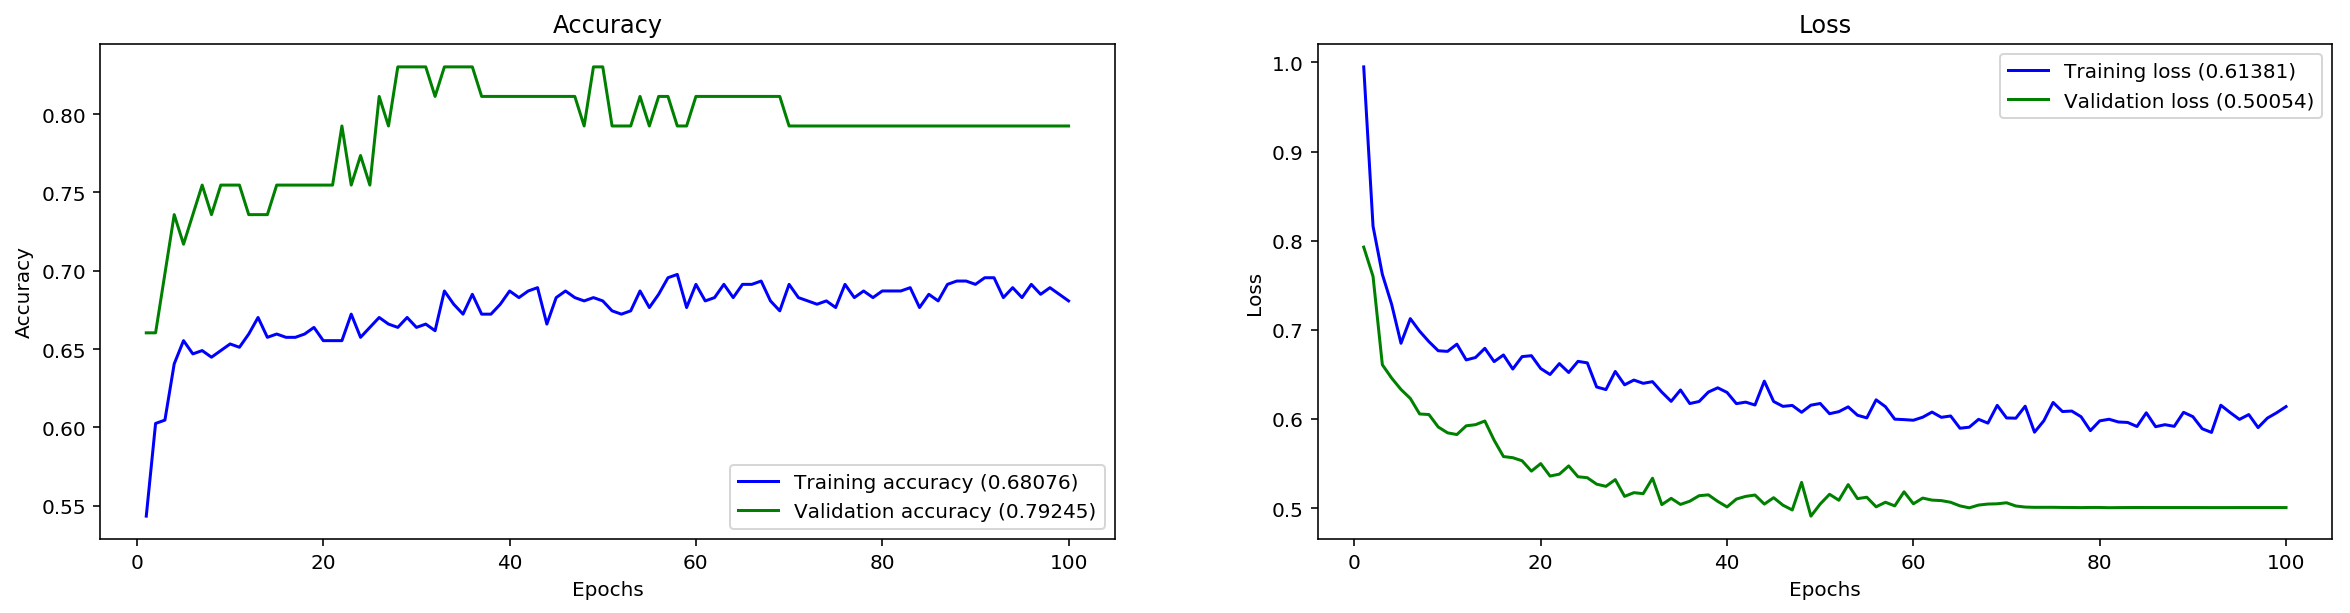

CPU times: user 1.35 s, sys: 258 ms, total: 1.61 s
Wall time: 1.27 s


In [54]:
%%time
#Plot Keras History
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Prediction Test

In [56]:
# prediction class 
y_pred = model.predict_classes(x_test, batch_size=32)
print ("prediction test return :",y_pred[1], "-", int_to_label[y_pred[1]])

prediction test return : 2 - normal


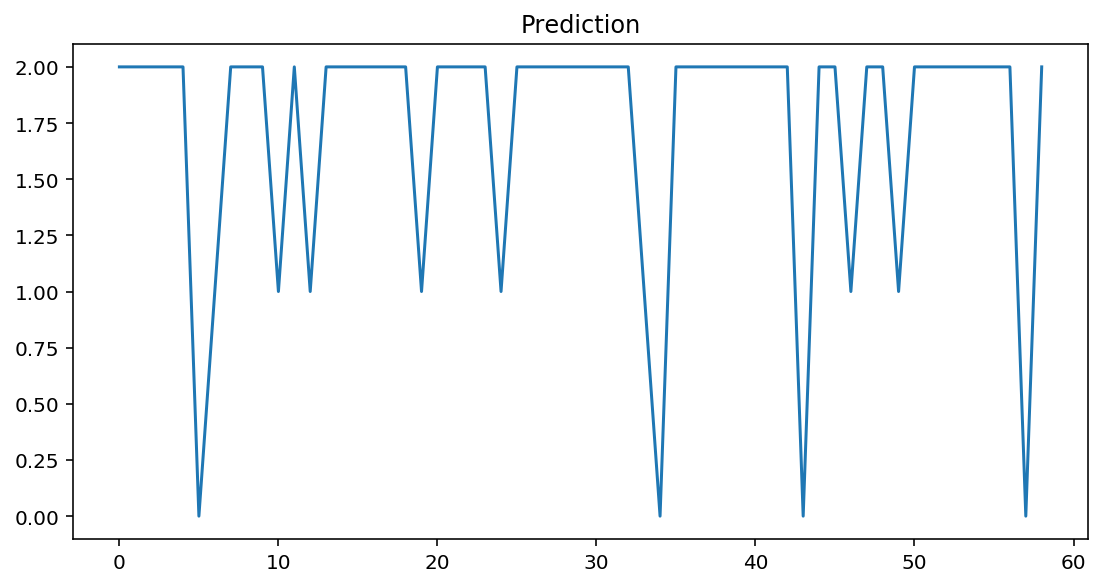

In [57]:
plt.figure(1,figsize=(20,10))
# plot Classification Metrics: Accuracy 
plt.subplot(221, title='Prediction')
plt.plot(y_pred)
plt.show()

### Loading a saved training model

In [58]:
print (best_model_file)

./best_model_trained.hdf5


In [59]:
### Loading a Check-Pointed Neural Network Model
# How to load and use weights from a checkpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# create model
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=64, dropout=0.05, recurrent_dropout=0.35, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.35, return_sequences=False))
model.add(Dense(len(CLASSES), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc','mse', 'mae', 'mape', 'cosine'])
model.summary()
# load weights
model.load_weights(best_model_file)
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

Build LSTM RNN model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 40, 64)            16896     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 29,411
Trainable params: 29,411
Non-trainable params: 0
_________________________________________________________________
Created model and loaded weights from file


### Test loaded model

In [60]:
# make a prediction
y_pred = model.predict_classes(x_test, batch_size=32)
#check scores
scores = model.evaluate(x_test, y_test, verbose=0)
print ("Model evaluation accuracy: ", round(scores[1]*100),"%")

Model evaluation accuracy:  79.0 %


#TODO -  more optimization, keep improving the model.

and one more todo. cheers!

#### Reference:
Classifying Heart Sounds Challenge 
http://www.peterjbentley.com/heartchallenge/        